In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import jax
import jax.numpy as jnp
import jax.random as jrand
import jax.scipy as jsp

import circuitmap as cm
from circuitmap.neural_waveform_demixing import _sample_gp

# Simulated photocurrent based on Schoeters et al

In [3]:
# first, set parameters. For now, we'll have to vary these by hand.
g = 1.0 # conductance
O_inf = 0.5 # fraction molecules open at infinity
O_0 = 0.0 # fraction molecules open at t = t_on
R_inf = 0.7 # fraction molecules recovered at infinity
R_0 = 1.0 # fraction recovered at t = t_on

# time constants
tau_o = 10.0
tau_r = 7.0

# time in ms
t_on = 5
t_off = 10

srate = 20000
secs_per_sample = 1 / srate
msecs_per_sample = secs_per_sample * 1e3

window_len = 1000
t = np.arange(window_len) * msecs_per_sample

In [4]:
t_on = -5.0
t_off = -2.0
conv_window_len = 25
left_bound = jnp.minimum(0, t_on * 1 / msecs_per_sample)
right_bound = left_bound + window_len + conv_window_len
t = jnp.arange(left_bound, right_bound) * msecs_per_sample
time_zero_idx = int(-jnp.minimum(t_on / msecs_per_sample, 0))

In [5]:
left_bound

DeviceArray(-100., dtype=float64, weak_type=True)

In [6]:
np.where(t == t_off)

(array([60]),)

In [7]:
if t_off >= 0:
    print(time_zero_idx + t_off / msecs_per_sample)
else:
    print(time_zero_idx + t_off / msecs_per_sample)

60.0


In [8]:
def _photocurrent_shape(O_inf, R_inf, tau_o, tau_r, g,
    t_on, t_off,
    window_len=900, msecs_per_sample=0.05, conv_window_len=25,
    ):
    
    
    # In order to correctly handle stim times which start at t < 0,
    # we need to work with a larger window and then crop later.
    # We also pad the window by conv_window_len to avoid zero
    # padding issues during the convolution step.
    left_bound = jnp.minimum(0, t_on / msecs_per_sample)
    right_bound = jnp.abs(left_bound) + window_len + conv_window_len
    t = jnp.arange(left_bound, right_bound) * msecs_per_sample

    # get the index where t=0 occurs. This is the beginning of the
    # window we'll return to the user.
    time_zero_idx = int(-jnp.minimum(t_on / msecs_per_sample, 0))

    mask_stim_on = jnp.where((t >= t_on) & (t <= t_off), 1.0, 0.0)
    mask_stim_off = jnp.where((t > t_off), 1.0, 0.0)

    # get index where stim is off
    index_t_off = time_zero_idx + int(jnp.round(t_off / msecs_per_sample))

    O_on = mask_stim_on * (O_inf - (O_inf - O_0) * jnp.exp(- (t - t_on)/(tau_o)))
    O_off = mask_stim_off * O_on[index_t_off] * jnp.exp(-(t - t_off)/tau_o)

    R_on = mask_stim_on * (R_inf - (R_inf - R_0) * jnp.exp(-(t - t_on)/tau_r))
    R_off = mask_stim_off * (1 - (1 - R_on[index_t_off]) * jnp.exp(-(t - t_off)/tau_r))

    # form photocurrent from each part
    i_photo = g * (O_on + O_off) * (R_on + R_off)

    # import pdb; pdb.set_trace()
    
    # convolve with gaussian to smooth
    x = jnp.linspace(-3, 3, conv_window_len)
    window = jsp.stats.norm.pdf(x, scale=25)
    i_photo = jsp.signal.convolve(i_photo, window, mode='same')
    i_photo /= (jnp.max(i_photo) + 1e-3)

    return (i_photo[time_zero_idx:time_zero_idx + window_len],
            O_on[time_zero_idx:time_zero_idx + window_len],
            O_off[time_zero_idx:time_zero_idx + window_len],
            R_on[time_zero_idx:time_zero_idx + window_len],
            R_off[time_zero_idx:time_zero_idx + window_len])


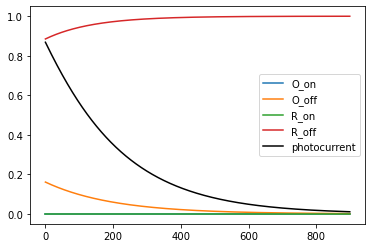

In [9]:
i_photo, O_on, O_off, R_on, R_off = _photocurrent_shape(
    O_inf, R_inf, tau_o, tau_r, g, t_on=-7.0, t_off=-2.0)
plt.plot(O_on, label='O_on')
plt.plot(O_off, label='O_off')
plt.plot(R_on, label='R_on')
plt.plot(R_off, label='R_off')
plt.plot(i_photo, label='photocurrent', color='black')

plt.legend()

## Sample photocurrent params

In [10]:
@jax.jit
def _sample_photocurrent_params(key):
    keys = jax.random.split(key, num=4)
    
    O_inf, R_inf = jrand.uniform(keys[0], minval=0.3, maxval=1.0, shape=(2,))
    tau_o = jrand.uniform(keys[1], minval=8, maxval=20)
    tau_r = jrand.uniform(keys[2], minval=3, maxval=12)
    g = 1.0

    return O_inf, R_inf, tau_o, tau_r, g

def _sample_scales(key, min_pc_fraction, max_pc_fraction,
        num_traces, min_pc_scale, max_pc_scale):
        # sample scale values for photocurrents.
        # Randomly set some traces to have no photocurrent
        # according to pc_fraction.

        pc_fraction = jrand.uniform(key, minval=min_pc_fraction,
            maxval=max_pc_fraction)
        key = jrand.fold_in(key, 0)
        pc_mask = jnp.where(
            jrand.uniform(key, shape=(num_traces,)) <= pc_fraction,
            1.0,
            0.0)
        key = jrand.fold_in(key, 0)
        pc_scales = jrand.uniform(key, shape=(num_traces,),
            minval=min_pc_scale, maxval=max_pc_scale)
        pc_scales *= pc_mask
        return pc_scales


def _sample_gp(key, pcs, gp_lengthscale=25, gp_scale=0.01, ):
    n_samples, trial_dur = pcs.shape
    # creates a distance matrix between indices,
    # much faster than a loop
    D = jnp.broadcast_to(jnp.arange(trial_dur), (trial_dur, trial_dur))
    D -= jnp.arange(trial_dur)[:,None]
    D = jnp.array(D, dtype=jnp.float64)
    K = jnp.exp(-D**2/(2 * gp_lengthscale**2)) + 1e-4 * jnp.eye(trial_dur)
    mean = jnp.zeros(trial_dur, dtype=jnp.float64)
    return gp_scale * jrand.multivariate_normal(key, mean=mean, cov=K, shape=(n_samples,))
sample_gp = jax.jit(_sample_gp)

@jax.jit
def _sample_experiment_noise_and_scales(
    key,
    cur_pc_template,
    prev_pc_template,
    next_pc_template,
    psc_background,
    min_pc_scale,
    max_pc_scale,
    min_pc_fraction,
    max_pc_fraction,
    prev_pc_fraction,
    gp_lengthscale,
    gp_scale,
    iid_noise_scale,
):
    num_traces, trial_dur = psc_background.shape

    keys = jrand.split(key, num=4)
    prev_pcs = _sample_scales(keys[0],
                              prev_pc_fraction, prev_pc_fraction,
                              num_traces, min_pc_scale, max_pc_scale)[:, None] * prev_pc_template

    cur_pcs = _sample_scales(keys[1],
                             min_pc_fraction, max_pc_fraction,
                             num_traces, min_pc_scale, max_pc_scale)[:, None] * cur_pc_template

    next_pcs = _sample_scales(keys[2],
                              min_pc_fraction, max_pc_fraction,
                              num_traces, min_pc_scale, max_pc_scale)[:, None] * next_pc_template

    # TODO: add GP and IID noise
    gp_noise = sample_gp(
        keys[3],
        cur_pcs,
        gp_lengthscale=gp_lengthscale,
        gp_scale=gp_scale,
    )

    iid_noise = iid_noise_scale * \
        jrand.normal(keys[3], shape=(num_traces, trial_dur))
    targets = cur_pcs
    observations = prev_pcs + cur_pcs + next_pcs + iid_noise + gp_noise + psc_background

    return observations, targets
    
import time

key = jrand.PRNGKey(5)
pc_shape_params = _sample_photocurrent_params(key)
prev_pc_shape = _photocurrent_shape(
    *pc_shape_params, t_on=-7.0, t_off=-2.0,
)[0]
curr_pc_shape = _photocurrent_shape(
    *pc_shape_params, t_on=5.0, t_off=10.0,
)[0]
next_pc_shape = _photocurrent_shape(
    *pc_shape_params, t_on=38.0, t_off=43.0
)[0]
psc_background = np.zeros((100,900))

t1 = time.time()
min_pc_scale = 0.05
max_pc_scale = 0.2
min_pc_fraction = 0.1
max_pc_fraction = 0.9
prev_pc_fraction = 0.1
obs, targets = _sample_experiment_noise_and_scales(
    key,
    curr_pc_shape,
    prev_pc_shape,
    next_pc_shape,
    psc_background,
    min_pc_scale,
    max_pc_scale,
    min_pc_fraction,
    max_pc_fraction,
    prev_pc_fraction,
    gp_lengthscale=25,
    gp_scale=0.01,
    iid_noise_scale=0.001
)
t2 = time.time() - t1
print(t2)

2.107820987701416


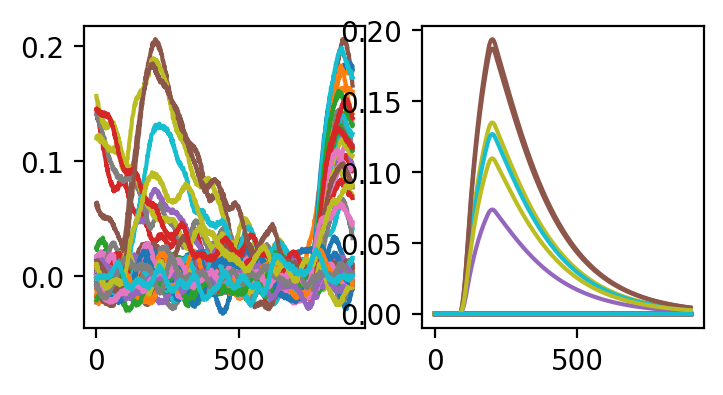

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4,2), dpi=200)
axs[0].plot(obs[0:50,:].T)
axs[1].plot(targets[0:50,:].T)
plt.show()

## Generate a single experiment with fixed number of traces

In order to parallelize over experiments, they all must be the same length. This way, we can vmap over the code to generate a single experiment, generating a batch of experiments at once. Then, inside of the dataLoader, we will subsample experiments to vary the length.

In [16]:
def sample_photocurrent_expts_batch(
    key, num_expts, num_traces_per_expt, trial_dur,
    pc_scale_range=(0.05, 2.0),
    iid_noise_scale_range=(0.01, 0.05),
    gp_scale_range=(0.01, 2.0),
    ):
    keys = jrand.split(key, num=num_expts)

    # generate all photocurrent templates.
    # We create a separate function to sample each of previous, current, and
    # next PSC shapes.
    sample_photocurrent_params_batch = jax.vmap(_sample_photocurrent_params)
    prev_photocurrent_shape_batch = jax.vmap(
        lambda params: _photocurrent_shape(*params, t_on=-7.0, t_off=-2.0),
    )
    curr_photocurrent_shape_batch = jax.vmap(
        lambda params: _photocurrent_shape(*params, t_on=5.0, t_off=10.0),
    )
    next_photocurrent_shape_batch = jax.vmap(
        lambda params: _photocurrent_shape(*params, t_on=38.0, t_off=43.0),
    )

    pc_shape_params = sample_photocurrent_params_batch(keys)

    prev_pc_shapes = prev_photocurrent_shape_batch(
        pc_shape_params,
    )[0]

    curr_pc_shapes = curr_photocurrent_shape_batch(
        pc_shape_params,
    )[0]

    next_pc_shapes = next_photocurrent_shape_batch(
        pc_shape_params,
    )[0]

    # Generate all psc traces from neural demixer.
    # This is faster than calling it separately many times.
    # Here, we generate noiseless PSC traces, since we will add noise
    # the summed traces (PCs + PSCs) at once.
    demixer = cm.NeuralDemixer()
    demixer.generate_training_data(
        size=num_expts * num_traces_per_expt,
        training_fraction=1.0,
        noise_std_upper=0.0,
        noise_std_lower=0.0,
        gp_scale=0.0,
    )
    pscs, _ = demixer.training_data
    pscs_batched = pscs.reshape(num_expts, num_traces_per_expt, trial_dur)

    sample_experiment_noise_and_scales_batch = jax.jit(jax.vmap(
        _sample_experiment_noise_and_scales,
        in_axes=(0, 0, 0, 0, 0, None, 0, None, None, None, None, 0, None),
    ))

    # mimic varying opsin / noise levels by experiment:
    # each experiment will have a different maximum photocurrent scale.
    max_pc_scales = jrand.uniform(
        key, minval=pc_scale_range[0] + 0.05, maxval=pc_scale_range[1],
        shape=(num_expts,)
    )
    gp_scales = jrand.uniform(
        key, minval=gp_scale_range[0], maxval=gp_scale_range[1],
        shape=(num_expts,)
    )
    

    min_pc_scale = 0.05
    min_pc_fraction = 0.1
    max_pc_fraction = 0.9
    prev_pc_fraction = 0.1
    gp_lengthscale = 50
    gp_scale = 0.1
    iid_noise_scale = 0.01
    return sample_experiment_noise_and_scales_batch(
        keys,
        curr_pc_shapes,
        prev_pc_shapes,
        next_pc_shapes,
        pscs_batched,
        min_pc_scale,
        max_pc_scales,
        min_pc_fraction,
        max_pc_fraction,
        prev_pc_fraction,
        gp_lengthscale,
        gp_scales,
        iid_noise_scale
    )

obs, targets = sample_photocurrent_expts_batch(
    key, 10, 100, 900,
    pc_scale_range=(0.5, 10.0),
    gp_scale_range=(0.01, 0.1),
)






Trace generation:   0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
import photocurrent_sim
obs, targets = photocurrent_sim.sample_photocurrent_expts_batch(
    key, 100, 100, 900,
    pc_scale_range=(0.05, 10.0),
    gp_scale_range=(0.01, 0.2),
    iid_noise_scale_range=(0.01, 0.1)
)

Trace generation:   0%|          | 0/10000 [00:00<?, ?it/s]

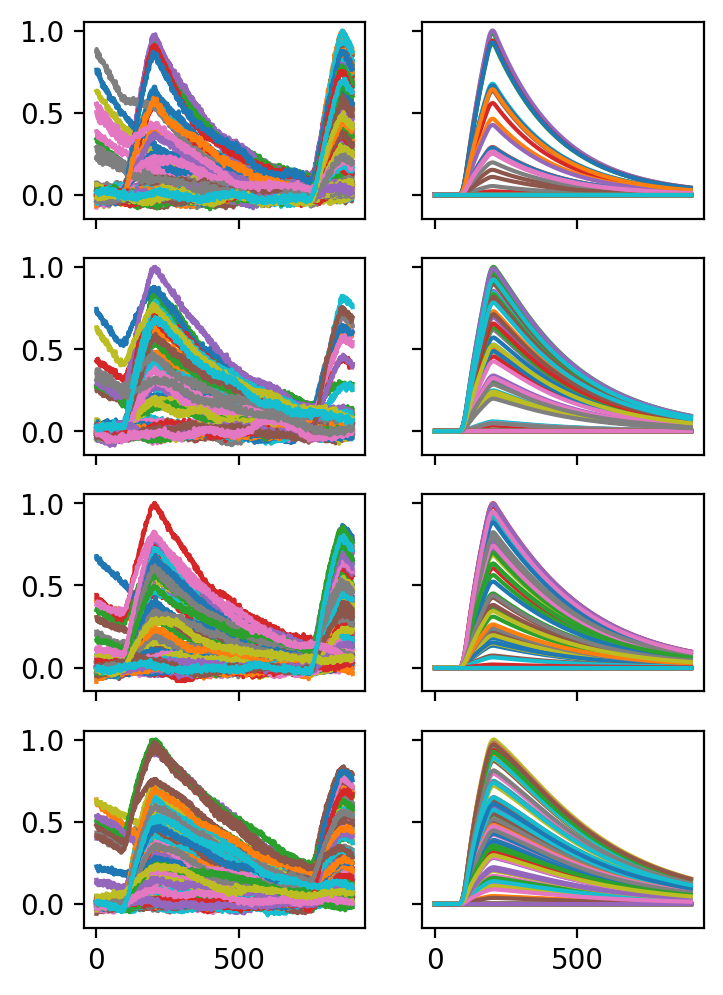

In [26]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(4,6), dpi=200, sharex=True, sharey=True)

for i in range(4):
    axs[i,0].plot(obs[i].T / np.max(obs[i]))
    axs[i,1].plot(targets[i].T / np.max(targets[i]))


In [14]:
pscs_batched.shape

NameError: name 'pscs_batched' is not defined

In [ ]:
obs, targets = _sample_experiment_noise_and_scales(
    key,
    curr_pc_shape,
    prev_pc_shape,
    next_pc_shape,
    psc_background,
    min_pc_scale,
    max_pc_scale,
    min_pc_fraction,
    max_pc_fraction,
    prev_pc_fraction,
    gp_lengthscale=25,
    gp_scale=0.01,
    iid_noise_scale=0.001
)

sample_experiment_batch = jax.vmap(
    _sample_experiment_noise_and_scales,
    in_axes=(0,0,0,0,0, None, None, None, None, None, None, None, None),
)

min_pc_scale = 0.05
max_pc_scale = 0.2
min_pc_fraction = 0.1
max_pc_fraction = 0.9
prev_pc_fraction = 0.1
gp_lengthscale = 25
gp_scale = 0.01
iid_noise_scale = 0.01
inputs, targets = sample_experiment_batch(
    keys,
    curr_pc_shapes,
    prev_pc_shapes,
    next_pc_shapes,
    pscs_batched,
    min_pc_scale,
    max_pc_scale,
    min_pc_fraction,
    max_pc_fraction,
    prev_pc_fraction,
    gp_lengthscale,
    gp_scale,
    iid_noise_scale
)

ValueError: vmap in_axes specification must be a tree prefix of the corresponding value, got specification (0, 0, 0, 0, 0) for value tree PyTreeDef((*, *, *, *, *, *, *, *, *, *, *, *, *)).

In [ ]:
def f(x,y):
    return x + y

xs = jnp.arange(10)
y = 1
jax.vmap(f, in_axes=(0,None))(xs,y)

DeviceArray([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [ ]:
def gen_photocurrent_data(
    key,
    trial_dur=900,
    num_expts=1000,
    num_traces_per_expt=500,
    photocurrent_scale_min=0.05,
    photocurrent_scale_max=1.0,
    psc_scale_max=1.0,
    psc_scale_min=0.01,
    psc_generation_kwargs=None,
    dtype=np.float32,
    ):


    # Generate all psc traces from neural demixer.
    # This is faster than calling it separately many times.
    # Here, we generate noiseless PSC traces, since we will add noise
    # the summed traces (PCs + PSCs) at once.
    if psc_generation_kwargs is None:
        psc_generation_kwargs = dict()
    demixer = cm.NeuralDemixer()
    demixer.generate_training_data(
        size=num_expts * num_traces_per_expt,
        training_fraction=1.0,
        noise_std_upper=0.0,
        noise_std_lower=0.0,
        gp_scale=0.0,
    )
    pscs, _ = demixer.training_data

    # generate all photocurrent templates
    

    # For each experiment, we generate a group of traces that share a common photocurrent component.
    # Some random fraction of these will _not_ have photocurrent present.
    for i in tqdm.trange(num_expts):

        
    return expts

array([ 2.50514044e+01+0.00000000e+00j,  2.50068223e+01+0.00000000e+00j,
        2.49326955e+01+0.00000000e+00j,  2.48292879e+01+0.00000000e+00j,
        2.46969667e+01+0.00000000e+00j,  2.45362003e+01+0.00000000e+00j,
        2.43475556e+01+0.00000000e+00j,  2.41316944e+01+0.00000000e+00j,
        2.38893698e+01+0.00000000e+00j,  2.36214218e+01+0.00000000e+00j,
        2.33287722e+01+0.00000000e+00j,  2.30124194e+01+0.00000000e+00j,
        2.26734331e+01+0.00000000e+00j,  2.23129476e+01+0.00000000e+00j,
        2.19321560e+01+0.00000000e+00j,  2.15323034e+01+0.00000000e+00j,
        2.11146802e+01+0.00000000e+00j,  2.06806152e+01+0.00000000e+00j,
        2.02314684e+01+0.00000000e+00j,  1.97686243e+01+0.00000000e+00j,
        1.92934844e+01+0.00000000e+00j,  1.88074606e+01+0.00000000e+00j,
        1.83119681e+01+0.00000000e+00j,  1.78084187e+01+0.00000000e+00j,
        1.72982144e+01+0.00000000e+00j,  1.67827408e+01+0.00000000e+00j,
        1.62633613e+01+0.00000000e+00j,  1.57414114